In [1]:
%pip install pythtb

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing necessary libraries
from pythtb import *
import matplotlib.pyplot as plt

# Initializing the Wannier90 model by reading the data files
pgda=w90(r"PdGa_Ham1",r"wannier90")
my_model=pgda.model(min_hopping_norm=0.01) # only hoppings with norm greater than 0.01 are considered

In [3]:
# To write the band velocity operator at a k-point
def calculate_v_euler_forward(k_vec, dk=0.01):
    H = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]])
    Hx = my_model._gen_ham([k_vec[0]+dk, k_vec[1], k_vec[2]])
    Hy = my_model._gen_ham([k_vec[0], k_vec[1]+dk, k_vec[2]])
    Hz = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]+dk])

    vx = (Hx-H)/dk
    vy = (Hy-H)/dk
    vz = (Hz-H)/dk
    return np.array((vx, vy, vz))

In [4]:
# method 1 ................

# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz(k_vec, eta=0.01):
    v = calculate_v_euler_forward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating L_z
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    
    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)

In [18]:

from joblib import Parallel, delayed
# Method 1 -- we need this in hall calculation

# Efficient computation of eigenvalues and Omega_xyz using parallel processing
def parallel_solve_and_calculate(k_points):
    evals = np.zeros((64, len(k_points)))
    Omega_xyz = np.zeros((64, len(k_points)))

    results = Parallel(n_jobs=-1)(delayed(solve_and_calculate_Omega_xyz)(k_point) for k_point in k_points)

    for i, (e_vals, Omega) in enumerate(results):
        evals[:, i] = e_vals
        Omega_xyz[:, i] = Omega

    return evals, Omega_xyz

# Create k-points

N = 16
kx = np.linspace(-0.5, 0.5, N, endpoint=False)
ky = np.linspace(-0.5, 0.5, N, endpoint=False)
kz = np.linspace(-0.5, 0.5, N, endpoint=False)

# Create 3D meshgrid and flatten
kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz, indexing='ij')
k_points = np.vstack([kx_grid.ravel(), ky_grid.ravel(), kz_grid.ravel()]).T  # shape (N^3, 3)

# Parallel computation of evals and Omega_xyz
evals, Omega_xyz = parallel_solve_and_calculate(k_points)


KeyboardInterrupt: 

In [22]:
# Orbital Hall conductivity

# we need energies (eval) where we take u = 6.87 and omega_xyz which we have already computed

def fermi_distribution(energies, T):
    KT = 26e-3
    y = 1/(1+np.exp((energies)/KT))
    return y


In [27]:
# using evals
u = np.linspace(-5.1,5.1,20)
response = []
for i in u:
  summation1 = fermi_distribution(evals-6.87-i, 300)
  result = np.sum(summation1* Omega_xyz)
  results = np.sum(result)
  results = results / (2 * np.pi)**3 / N**3
  response.append(results)
  print(results)

0.030812860801584827
0.22737377245942209
0.14469657695759855
0.2439664702724275
0.27560533226024725
0.24700113488064498
0.4167730078341502
0.3784487415407446
0.46381817633811445
0.3354625792162589
0.40454805690677675
0.049771954866185616
1.2926224344441715
2.992071849575923
0.7426508159290871
0.9186264561849055
1.3786997962091951
1.1928230199324839
0.9534464560439778
0.8640161227536448


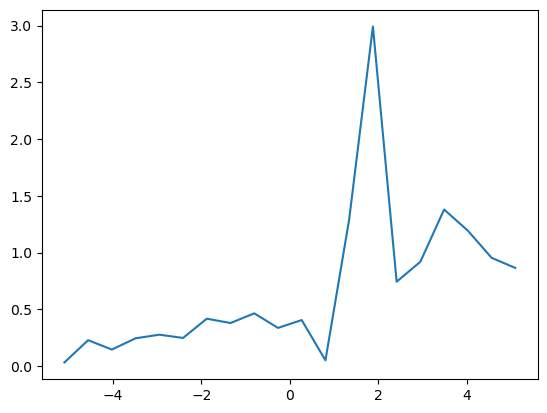

In [28]:
plt.plot(u,response)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Given data
N_vals = np.array([8, 10, 12, 14, 20])
ohc_vals = np.array([0.41, 0.34, 0.32, 0.31, 0.29])

# Define fitting function
def fit_func(N, a, b, c):
    return a / N**b + c

# Fit the data
params, _ = curve_fit(fit_func, N_vals, ohc_vals)

# Generate smooth curve
N_fit = np.linspace(6, 3000, 200)
ohc_fit = fit_func(N_fit, *params)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(N_vals, ohc_vals, 'o', label='Data')
plt.plot(N_fit, ohc_fit, '-', label='Fit: a/N^b + c')
plt.xlabel('N')
plt.ylabel('OHC')
plt.title('OHC vs N')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
